<a href="https://colab.research.google.com/github/misanchz98/bitcoin-direction-prediction/blob/main/03_modeling/03_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Modelización y evaluación de modelos

Este *notebook* tiene por objetivo realizar el análisis comparativo del desempeño de diferentes redes neuronales aplicadas a la estimación diaria del movimiento del precio de Bitcoin, planteado como un problema de clasificación binaria, donde se asigna el valor 0 si el precio disminuye y 1 si aumenta.
Para ello nos centraremos especificamente en cuatro arquitecturas:
1. LSTM
2. GRU
3. CNN+LSTM
4. CNN+GRU

Asimismo se compararan y evaluararan  dichos modelos en dos escenarios o estrategias de *trading*:
- *longonly*
  - Qué hace: Solo toma posiciones largas (compra).
  - Objetivo: Ganar cuando el precio sube.
  - Ejemplo: Compras BTC esperando que suba, y vendes más caro.
  - Ventaja: Menor riesgo que el shorting, especialmente en mercados alcistas.
  - Limitación: No se beneficia de caídas del mercado.
- *longshort*
  - Qué hace: Puede tomar ambas posiciones, largas y cortas.
  - Objetivo: Aprovechar tanto subidas como bajadas.
  - Ejemplo: Compras BTC y vendes ETH si crees que BTC va a subir y ETH a bajar.
  - Ventaja: Más flexible, puede generar ganancias en cualquier dirección del mercado.
  - Limitación: Más compleja, requiere buena gestión de riesgo.

Por último, se utilizaran las funciones `run_pipeline_random_search` y `run_pipeline_evaluate_models` del fichero `pipelines.py` para llevar a cabo el ajuste de hiperparámetros y la evaluación de los modelos sucesivamente.

## 🔹 1. Librerías
Instalamos e importamos las librerías necesarias para manipulación de datos, visualización, machine learning y deep learning.


In [1]:
# =============================================================================
# LIBRERIAS
# =============================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf

import warnings

# Establecer el nivel de advertencias a "ignore" para ignorar todas las advertencias
warnings.filterwarnings("ignore")

## 🔹 2. Módulos
Importamos las funciones `run_pipeline_random_search` y `run_pipeline_evaluate_models` del fichero `pipelines.py`.

In [2]:
# 1️⃣ REINICIO COMPLETO - Ir al directorio raíz y limpiar todo
import os
import shutil

# Volver al directorio raíz de Colab
os.chdir('/content')

# Eliminar CUALQUIER rastro del repositorio
for item in os.listdir('/content'):
    if 'bitcoin' in item.lower():
        try:
            if os.path.isdir(item):
                shutil.rmtree(item)
            else:
                os.remove(item)
            print(f"Eliminado: {item}")
        except:
            pass

# Verificar que estamos en /content y está limpio
print(f"Directorio actual: {os.getcwd()}")
print("Contenido actual:")
!ls -la

Directorio actual: /content
Contenido actual:
total 16
drwxr-xr-x 1 root root 4096 Sep  3 13:36 .
drwxr-xr-x 1 root root 4096 Sep  8 13:41 ..
drwxr-xr-x 4 root root 4096 Sep  3 13:35 .config
drwxr-xr-x 1 root root 4096 Sep  3 13:36 sample_data


In [3]:
# 2️⃣ CLONAR FRESCO
!git clone https://github.com/misanchz98/bitcoin-direction-prediction.git

# Verificar que se clonó correctamente
print("Verificando estructura:")
!ls -la bitcoin-direction-prediction/

Cloning into 'bitcoin-direction-prediction'...
remote: Enumerating objects: 304, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 304 (delta 33), reused 45 (delta 19), pack-reused 240 (from 1)
Receiving objects: 100% (304/304), 20.82 MiB | 20.36 MiB/s, done.
Resolving deltas: 100% (135/135), done.
Verificando estructura:
total 36
drwxr-xr-x 6 root root 4096 Sep  8 13:43 .
drwxr-xr-x 1 root root 4096 Sep  8 13:43 ..
drwxr-xr-x 3 root root 4096 Sep  8 13:43 01_data_preparation
drwxr-xr-x 5 root root 4096 Sep  8 13:43 02_data_analysis
drwxr-xr-x 3 root root 4096 Sep  8 13:43 03_modeling
drwxr-xr-x 8 root root 4096 Sep  8 13:43 .git
-rw-r--r-- 1 root root 4737 Sep  8 13:43 .gitignore
-rw-r--r-- 1 root root 1920 Sep  8 13:43 README.md


In [4]:
# 3️⃣ NAVEGAR CORRECTAMENTE
import sys
import os

# Cambiar al directorio de modeling
os.chdir('/content/bitcoin-direction-prediction/03_modeling')

# Verificar que estamos en el lugar correcto
print(f"Directorio actual: {os.getcwd()}")
print("Contenido:")
!ls -la

# Verificar que existe utils/
print("\nContenido de utils/:")
!ls -la utils/

Directorio actual: /content/bitcoin-direction-prediction/03_modeling
Contenido:
total 528
drwxr-xr-x 3 root root   4096 Sep  8 13:43 .
drwxr-xr-x 6 root root   4096 Sep  8 13:43 ..
-rw-r--r-- 1 root root 526546 Sep  8 13:43 03_modeling.ipynb
drwxr-xr-x 2 root root   4096 Sep  8 13:43 utils

Contenido de utils/:
total 76
drwxr-xr-x 2 root root  4096 Sep  8 13:43 .
drwxr-xr-x 3 root root  4096 Sep  8 13:43 ..
-rw-r--r-- 1 root root  2485 Sep  8 13:43 callbacks.py
-rw-r--r-- 1 root root 21847 Sep  8 13:43 cross_validation.py
-rw-r--r-- 1 root root  5504 Sep  8 13:43 general.py
-rw-r--r-- 1 root root     0 Sep  8 13:43 __init__.py
-rw-r--r-- 1 root root  2649 Sep  8 13:43 models.py
-rw-r--r-- 1 root root  8514 Sep  8 13:43 pipelines.py
-rw-r--r-- 1 root root 14126 Sep  8 13:43 random_search.py


In [5]:
# 4️⃣ IMPORTAR CORRECTAMENTE
import sys
import os
import importlib.util

# Agregar el directorio actual al path
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)

pipeline_path = os.path.join(current_dir, 'utils', 'pipelines.py')
print(f"Intentando cargar desde: {pipeline_path}")

if os.path.exists(pipeline_path):
    spec = importlib.util.spec_from_file_location("pipelines", pipeline_path)
    pipelines_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(pipelines_module)
    run_pipeline_random_search = pipelines_module.run_pipeline_random_search
    run_pipeline_evaluate_models = pipelines_module.run_pipeline_evaluate_models
    print("✅ Funciones cargadas con éxito")
else:
    print("❌ El archivo no existe")

Intentando cargar desde: /content/bitcoin-direction-prediction/03_modeling/utils/pipelines.py
✅ Plan B exitoso - función cargada!


## 🔹 3. Semillas
Para garantizar **reproducibilidad** en los experimentos, es importante fijar las semillas de las librerías que generan números aleatorios. La función `reset_random_seeds(seed=42)` establece un entorno reproducible para experimentos de *machine learning* y *deep learning*.

### ¿Qué hace esta función?

1. **Python**: Establece la semilla para el módulo `random`.
2. **NumPy**: Fija la semilla para las operaciones aleatorias de NumPy.
3. **TensorFlow**: Configura la semilla para las operaciones aleatorias de TensorFlow.
4. **Hash interno de Python**: Define `PYTHONHASHSEED` para asegurar que el orden de estructuras como diccionarios sea consistente.
5. **Operaciones determinísticas**: Activa el modo determinista en TensorFlow para garantizar que las operaciones se comporten de forma predecible.
6. **Manejo de errores**: Intenta habilitar el determinismo experimental de TensorFlow y muestra un mensaje si no está disponible.


De este modo logramos que los modelos se entrenen con resultados consistentes entre ejecuciones.

In [6]:
def reset_random_seeds(seed=42):
    # 1. Python built-in random
    random.seed(seed)

    # 2. NumPy random
    np.random.seed(seed)

    # 3. TensorFlow random
    tf.random.set_seed(seed)

    # 4. Hash seed para operaciones de Python
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 5. Operaciones determinísticas
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    # 6. Configurar determinismo (con manejo de errores)
    try:
        tf.config.experimental.enable_op_determinism()
        print("✅ Determinismo habilitado")
    except Exception as e:
        print(f"⚠️ enable_op_determinism no disponible: {e}")

    print(f"✅ Seeds configuradas con valor: {seed}")
reset_random_seeds()

✅ Determinismo habilitado
✅ Seeds configuradas con valor: 42


## 🔹 4. Conjunto de Datos
Importamos el conjunto de datos en nuestro entorno de trabajo. Se encuentran almacenados en un archivo CSV llamado `btc_historical_data_eda.csv`, cuya obtención se explica en el *notebook* `02_data_analysis.ipynb`.

In [7]:
# Importamos CSV
url = 'https://raw.githubusercontent.com/misanchz98/bitcoin-direction-prediction/main/02_data_analysis/data/btc_historical_data_eda.csv'
df_bitcoin = pd.read_csv(url, parse_dates=['Open time'])
df_bitcoin

,Open time,Close,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Range,Candle,Target,CMF_20,MFI_14,...,c2_ta_tendencia,c3_ta_tendencia,c1_ta_momentum,c2_ta_momentum,c3_ta_momentum,c4_ta_momentum,c5_ta_momentum,c1_ta_volatilidad,c2_ta_volatilidad,c3_ta_volatilidad
0,2017-10-05,4292.43,9158.0,351.042019,1.483037e+06,245.00,83.84,1,0.081329,56.225018,...,1.426309,-0.136861,1.317719,-0.126726,-1.676720,1.289633,0.019128,-4.644643,-0.938175,-0.259897
1,2017-10-06,4369.00,6546.0,226.148177,9.881066e+05,125.00,50.01,1,0.090972,62.048701,...,1.684975,-0.223654,1.843789,-0.313902,-0.766032,1.200655,0.108543,-4.656021,-1.404483,-0.298095
2,2017-10-07,4423.00,4804.0,145.313076,6.371469e+05,166.94,54.00,1,0.072898,60.780168,...,1.837639,-0.272101,1.714315,0.851111,-1.474281,-0.169404,-0.611932,-4.658149,-1.694457,-0.310605
3,2017-10-08,4640.00,7580.0,280.094854,1.268661e+06,233.00,215.00,1,0.064115,66.225272,...,2.655718,-0.595153,4.539268,-1.327677,-1.397994,0.344940,0.095779,-4.643444,-2.930102,-0.299058
4,2017-10-09,4786.95,10372.0,350.756559,1.654275e+06,339.98,146.95,0,0.105281,66.423592,...,3.068594,-0.711866,4.065484,0.284535,-0.496135,-0.373562,-0.383308,-4.619178,-3.116037,-0.259659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,2025-08-16,117380.66,1179842.0,2995.228650,3.521588e+08,755.01,38.62,1,-0.078079,61.679789,...,-2.974279,-0.597347,-1.738575,-0.246759,0.045690,1.947962,-0.826190,11.130802,0.715864,-3.617415
2873,2025-08-17,117405.01,1177563.0,2804.731130,3.307994e+08,1402.79,24.35,0,-0.071478,61.441782,...,-3.056170,-0.520901,-2.679964,0.452454,-1.078307,1.833305,-0.382838,11.062656,0.708259,-3.717682
2874,2025-08-18,116227.05,3345487.0,7647.218200,8.850528e+08,2903.61,-1177.96,0,-0.058026,54.527915,...,-3.371373,-0.335897,-3.708156,1.216496,-0.767095,1.913662,1.633951,11.085307,1.427748,-3.651715
2875,2025-08-19,112872.94,3291170.0,8609.360780,9.840874e+08,3993.11,-3354.11,1,-0.133646,53.037041,...,-4.158761,0.112011,-5.328226,0.713262,0.105456,1.232647,-1.954862,11.229262,3.161925,-3.269720


## 🔹 5. Modelización

En esta fase se realizará el ajuste de hiperparámetros para cuatro arquitecturas distintas: LSTM, GRU, CNN+LSTM y CNN+GRU, con el objetivo de identificar la configuración que ofrezca el mejor rendimiento predictivo. Para cada arquitectura se seleccionará el modelo más eficiente, el cual será sometido posteriormente a una evaluación exhaustiva. Antes de comenzar, es necesario realizar los siguientes pasos previos::

1. Establecemos la columna `Open time` como índice del conjunto de datos.
2. Creamos la columna `Return`:

```python
df_bitcoin["Return"] = np.log(df_bitcoin["Close"] / df_bitcoin["Close"].shift(1)).fillna(0)
```

  - **¿Qué significa?**

    - `df_bitcoin["Close"]` → Precio de cierre del Bitcoin.
    - `df_bitcoin["Close"].shift(1)` → Precio de cierre del día anterior.
    - `df_bitcoin["Close"] / df_bitcoin["Close"].shift(1)` → Retorno simple diario:

  - **Fórmula del retorno simple**:
$$
\text{Retorno simple} = \frac{P_t}{P_{t-1}}
$$

    - `np.log(...)` → Retorno logarítmico, que tiene varias ventajas:
      - Es **aditivo en el tiempo**: la suma de retornos logarítmicos de varios días es igual al log del retorno total.
      - Maneja mejor la **volatilidad** y los efectos de la **capitalización continua**.

    - `.fillna(0)` → El primer día no tiene precio anterior, se rellena con 0 para evitar valores nulos.


  - **¿Para qué se usa?** En nuestro pipeline de trading:

    - `Return` no es la variable objetivo (`y`), sino información adicional.
    - Se utiliza para calcular métricas financieras, principalmente el **Sharpe ratio**.
    - Dependiendo de la estrategia (`longonly`, `longshort`, `shortonly`), se combina con las predicciones `y_pred` para simular **ganancias o pérdidas**.

In [8]:
# Establecemos columna 'Open time' como indice
df_bitcoin["Open time"] = pd.to_datetime(df_bitcoin["Open time"])
df_bitcoin = df_bitcoin.set_index("Open time")

# Creamos la columna Return
df_bitcoin["Return"] = np.log(df_bitcoin["Close"] / df_bitcoin["Close"].shift(1)).fillna(0)

### 📈 Estrategia LONGONLY

Configuración del experimento:
  Estrategia: longonly
  Métrica: sharpe
  Iteraciones: 5
Ejecutando Random Search con 5 combinaciones y 4 modelos...
Estrategia de trading: longonly
Métrica de optimización: sharpe

Combinación 1/5: {'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 50, 'dropout': 0.2, 'lstm_units': 32, 'cnn_filters': 16, 'kernel_size': 2}
  Evaluando LSTM (1/20)
    Score: 0.6640 ± 0.7118 (n_folds=3)
  Evaluando GRU (2/20)
    Score: 0.8118 ± 0.6763 (n_folds=3)
  Evaluando LSTM_CNN (3/20)
    Score: 0.7789 ± 0.1973 (n_folds=3)
  Evaluando GRU_CNN (4/20)
    Score: 0.6961 ± 0.9947 (n_folds=3)

Combinación 2/5: {'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 50, 'dropout': 0.3, 'lstm_units': 32, 'cnn_filters': 64, 'kernel_size': 3}
  Evaluando LSTM (5/20)
    Score: 0.6650 ± 0.9452 (n_folds=3)
  Evaluando GRU (6/20)
    Score: 0.7445 ± 1.1442 (n_folds=3)
  Evaluando LSTM_CNN (7/20)
    Score: 0.4533 ± 0.7459 (n_folds=3)
  Evaluando GRU_CNN (8/20)
    Score: 1.164

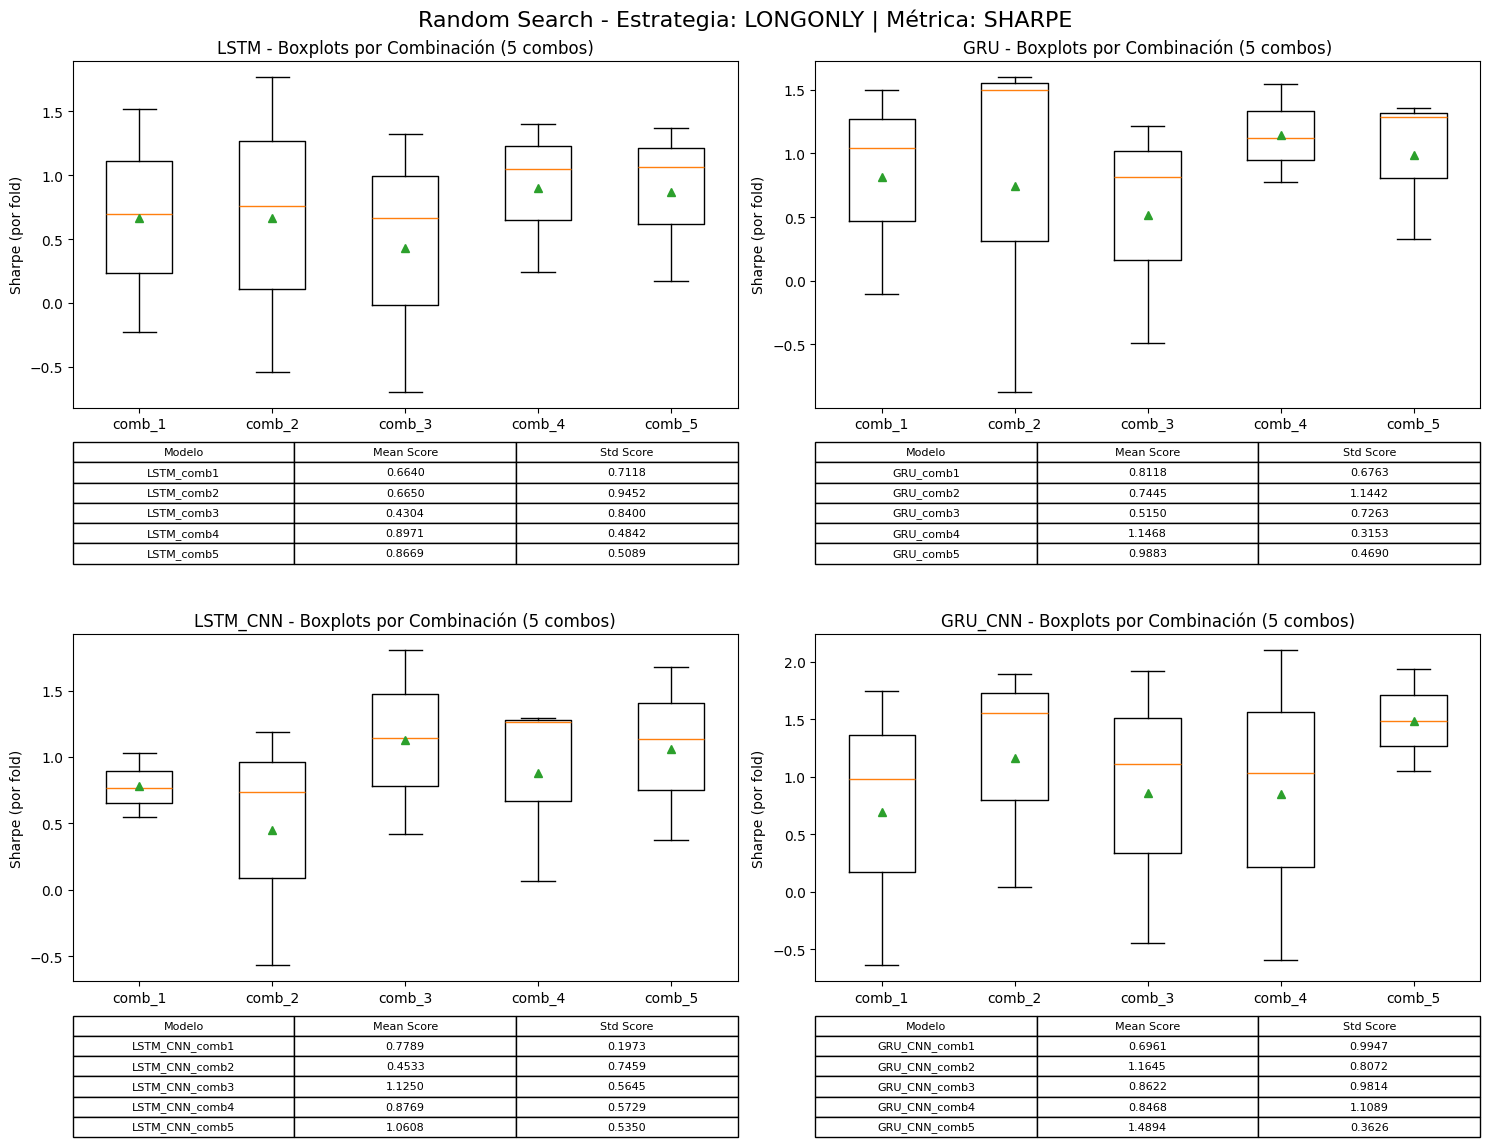

In [9]:
# Ejecutar la búsqueda - longonly
results_longonly = run_pipeline_random_search(
    df_bitcoin,
    target_col="Target",
    return_col="Return",
    window_size=30,
    horizon=1,
    test_size=0.2,
    strategy="longonly",   # longonly | shortonly | longshort
    scoring="sharpe",      # sharpe | accuracy | f1 | ...
    n_iter=5               # número de combinaciones a probar
)

In [10]:
# Obtener un modelo específico
best_model_lstm_longonly = results_longonly.get_model_by_id("LSTM_comb4")
best_model_gru_longonly = results_longonly.get_model_by_id("GRU_comb4")
best_model_cnn_lstm_longonly = results_longonly.get_model_by_id("LSTM_CNN_comb5")
best_model_cnn_gru_longonly = results_longonly.get_model_by_id("GRU_CNN_comb5")

### 📈 Estrategia LONGSHORT

In [12]:
# Ejecutar la búsqueda - longshort
results_longshort = run_pipeline_random_search(
    df_bitcoin,
    target_col="Target",
    return_col="Return",
    window_size=30,
    horizon=1,
    test_size=0.2,
    strategy="longshort",   # longonly | shortonly | longshort
    scoring="sharpe",      # sharpe | accuracy | f1 | ...
    n_iter=5               # número de combinaciones a probar
)

Configuración del experimento:
  Estrategia: longshort
  Métrica: sharpe
  Iteraciones: 5
Ejecutando Random Search con 5 combinaciones y 4 modelos...
Estrategia de trading: longshort
Métrica de optimización: sharpe

Combinación 1/5: {'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 50, 'dropout': 0.2, 'lstm_units': 32, 'cnn_filters': 16, 'kernel_size': 2}
  Evaluando LSTM (1/20)
    Score: 0.6165 ± 0.4813 (n_folds=3)
  Evaluando GRU (2/20)
    Score: 0.3487 ± 1.0216 (n_folds=3)
  Evaluando LSTM_CNN (3/20)
    Score: 0.3790 ± 0.8674 (n_folds=3)
  Evaluando GRU_CNN (4/20)
    Score: 0.7094 ± 0.9130 (n_folds=3)

Combinación 2/5: {'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 50, 'dropout': 0.3, 'lstm_units': 32, 'cnn_filters': 64, 'kernel_size': 3}
  Evaluando LSTM (5/20)
    Score: 0.3095 ± 0.5419 (n_folds=3)
  Evaluando GRU (6/20)
    Score: 0.0759 ± 1.0978 (n_folds=3)
  Evaluando LSTM_CNN (7/20)
    Score: -0.2860 ± 0.4392 (n_folds=3)
  Evaluando GRU_CNN (8/20)
    Score: 0.

KeyboardInterrupt: 

In [ ]:
# Obtener un modelo específico
best_model_lstm_longshort = results_longshort.get_model_by_id("LSTM_comb5")
best_model_gru_longshort = results_longshort.get_model_by_id("GRU_comb5")
best_model_cnn_lstm_longshort = results_longshort.get_model_by_id("LSTM_CNN_comb3")
best_model_cnn_gru_longshort = results_longshort.get_model_by_id("GRU_CNN_comb5")

## 🔹 6. Evaluación
Finalmente, se evaluarán los cuatro modelos más destacados de cada arquitectura mediante diversas métricas de clasificación y financieras, con el fin de determinar cuál ofrece el mejor rendimiento predictivo y mayor rentabilidad.

### 📈 Estrategia LONGONLY

Dataset: 2877 muestras, 42 features
Secuencias creadas: 2847 muestras con ventana=30

Evaluando modelo: LSTM
  Fold 0: Sharpe=0.080, AUC=0.497
  Fold 1: Sharpe=1.276, AUC=0.539
  Fold 2: Sharpe=0.857, AUC=0.492
  LSTM: 3 folds válidos

Evaluando modelo: GRU
  Fold 0: Warning - modelo predice solo una clase
  Fold 0: Sharpe=0.000, AUC=0.500
  Fold 1: Sharpe=0.982, AUC=0.537
  Fold 2: Sharpe=0.325, AUC=0.496
  GRU: 3 folds válidos

Evaluando modelo: LSTM_CNN
  Fold 0: Sharpe=0.362, AUC=0.504
  Fold 1: Sharpe=1.062, AUC=0.535
  Fold 2: Sharpe=1.365, AUC=0.537
  LSTM_CNN: 3 folds válidos

Evaluando modelo: GRU_CNN
  Fold 0: Sharpe=-0.027, AUC=0.516
  Fold 1: Sharpe=1.046, AUC=0.530
  Fold 2: Sharpe=1.301, AUC=0.498
  GRU_CNN: 3 folds válidos

=== RESUMEN ===
          sharpe             auc         cum_return         max_drawdown    
            mean     std    mean     std       mean     std         mean std
model                                                                       
GRU 

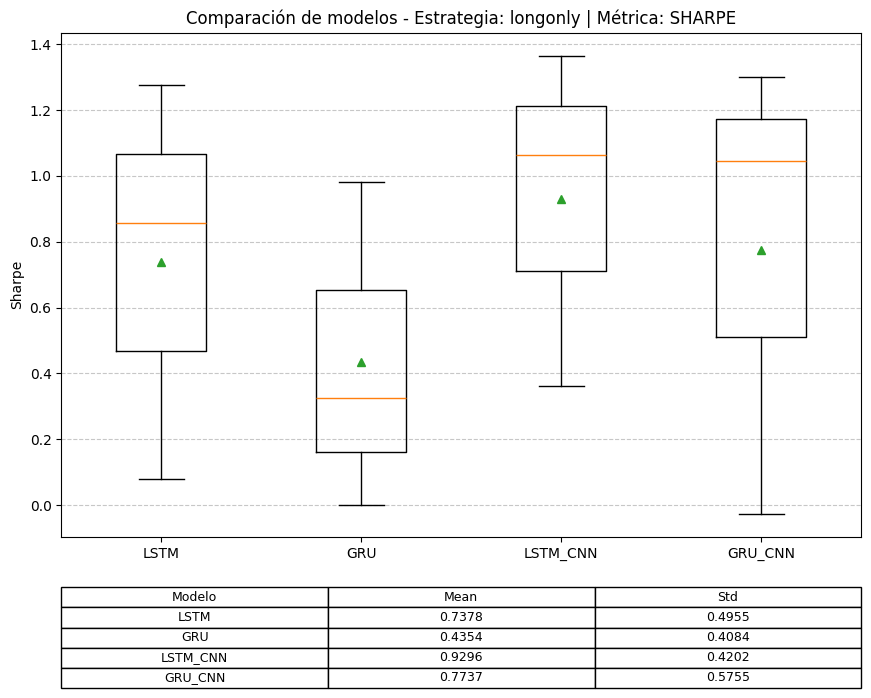

In [11]:
# Diccionario con tus modelos
models_to_evaluate = {
    "LSTM": best_model_lstm_longonly,
    "GRU": best_model_gru_longonly,
    "LSTM_CNN": best_model_cnn_lstm_longonly,
    "GRU_CNN": best_model_cnn_gru_longonly
}

# Ejecutar evaluación
results_df = run_pipeline_evaluate_models(
    df=df_bitcoin,  # tu DataFrame con los datos
    models_dict=models_to_evaluate,
    target_col="Target",
    return_col="Return",
    window_size=30,
    strategy="longonly",
    cv_params={
        "n_splits": 5,
        "n_test_splits": 1,
        "min_train_splits": 2
    }
)

### 📈 Estrategia LONGSHORT

In [ ]:
# Diccionario con tus modelos
models_to_evaluate = {
    "LSTM": best_model_lstm_longshort,
    "GRU": best_model_gru_longshort,
    "LSTM_CNN": best_model_cnn_lstm_longshort,
    "GRU_CNN": best_model_cnn_gru_longshort
}

# Ejecutar evaluación
results_df = run_pipeline_evaluate_models(
    df=df_bitcoin,  # tu DataFrame con los datos
    models_dict=models_to_evaluate,
    target_col="Target",
    return_col="Return",
    window_size=30,
    strategy="longonly",
    cv_params={
        "n_splits": 5,
        "n_test_splits": 1,
        "min_train_splits": 2
    }
)